# CRNN usando PyTorch Lightning
## Objetivos

- Importar una base de datos de audio
- Definir un modulo Dataset
- Definir un modelo convolucional - recurrente para clasificacion de audio

## Instalar e importar bibliotecas


In [1]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
# !mkdir -p ./data/esc50
# !curl -L -o ./data/esc50/esc-50.zip https://www.kaggle.com/api/v1/datasets/download/mmoreaux/environmental-sound-classification-50
# !unzip -o ./data/esc50/esc-50.zip -d ./data/esc50

## Definición de hiperparámetros de la red

In [3]:
torch.manual_seed(47)
BATCH_SIZE = 32
NUM_EPOCHS = 40 
LEARNING_RATE = 1e-4
NUM_WORKERS = 4
CLASES = 50

ANNOTATIONS_FILE = './data/esc50/esc50.csv'
AUDIO_DIR = './data/esc50/audio/audio/44100'
SAMPLE_RATE = 22_050
MAX_LEN_SEC = 5

In [4]:
all_csv = pd.read_csv(ANNOTATIONS_FILE)
print(all_csv.head(5))

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


torch.Size([1, 220500]) 44100


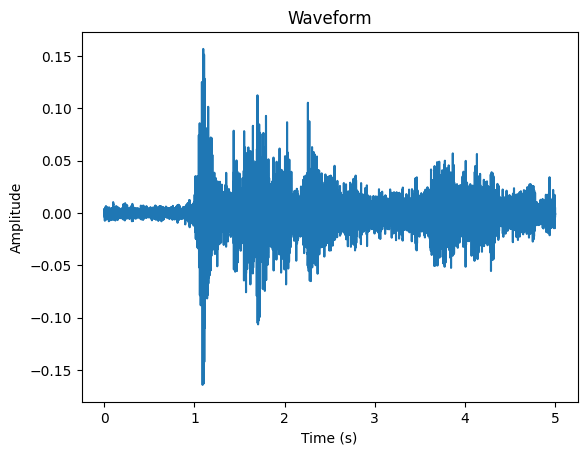

In [5]:
# Load the audio file
path = os.path.join(AUDIO_DIR, all_csv.iloc[5]['filename'])
waveform, sample_rate = torchaudio.load(path)
print(waveform.shape, sample_rate)
# Create a time axis
time_axis = torch.arange(0, waveform.shape[-1]) / sample_rate
# Plot the waveform
plt.plot(time_axis, waveform[0])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()

Ejemplo: ./data/esc50/audio/audio/44100/1-101296-B-19.wav


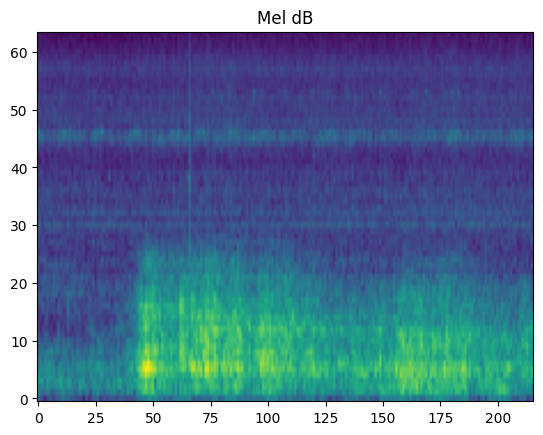

In [6]:
print("Ejemplo:", path)
waveform, native_sr = torchaudio.load(path)
waveform = waveform.mean(0, keepdim=True)  # mono
if native_sr != SAMPLE_RATE:
    waveform = T.Resample(native_sr, SAMPLE_RATE)(waveform)

mel_spec = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
mel = mel_spec(waveform)                    # [1, 64, T]
mel_db = torchaudio.transforms.AmplitudeToDB()(mel)
plt.imshow(mel_db[0], origin='lower', aspect='auto'); plt.title('Mel dB'); plt.show()

### Definicion de clase Dataset para Enviromental

El dataset se encuentra implementado en la clase `EnviromentalDataset` dentro del archivo [data_module.py](./crnn_utils/datamodule.py). Dentro de esta clase se cargan y procesan todos y cada uno de los datos de dataset. Ademas se adicionó un parámetro para modificar los datos dependiendo de si el modo de ejecución es entrenamiento o no.

En el caso de que el dataset se cargue en modo de entrenamiento (`training=True`) entonces se aplican transformaciones adicionales tanto a nivel de la señal del audio como en el espectro de frecuencia luego de aplicar la transformación MEL.

Las clases que aplican las distintas transformaciones tanto a nivel del dominio temporal como el de frecuencia se encuentran en el archivo [augmentations.py](./crnn_utils/augmentations.py)

### Audio Augmentations (Dominio Temporal)

La clase `AudioAugmentations` aplica transformaciones directamente sobre la señal de audio en el dominio temporal:

1. **Volume Gain**
- Modifica la amplitud de la señal aplicando ganancias aleatorias entre -6dB y +6dB
- Simula diferentes niveles de grabación o distancias del micrófono
2. **Gaussian Noise**
- Añade ruido gaussiano con SNR (Signal-to-Noise Ratio) aleatorio entre 10-30 dB
- Simula condiciones de grabación con ruido de fondo
3. **Time Stretching**
- Modifica la velocidad de reproducción (0.9x - 1.1x) sin cambiar el pitch
- Usa resampling para crear variaciones temporales sutiles

### Spectrogram Augmentations (Dominio Frecuencial)

La clase `SpectrogramAugmentations` implementa la técnica SpecAugment:

Aplica múltiples máscaras para aumentar la robustez del modelo

1. **Frequency Masking:** Enmascara bandas de frecuencia aleatorias
2. **Time Masking:** Enmascara segmentos temporales aleatorios.



A continuación se obtiene un sample para verificar el shape de la salida luego de aplicar la transformación MEL

In [7]:
from crnn_utils.datamodule import EnviromentalDataset

mel_transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)
env_dataset = EnviromentalDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC)
env_dataloader = DataLoader(env_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Tomar un batch para fijar dimensiones
sample_batch, _ = next(iter(env_dataloader))  # [B, 1, 64, T]
_, C, H, W = sample_batch.shape
print(f"Input mel shape: C={C}, H(n_mels)={H}, W(frames)={W}")

Input mel shape: C=1, H(n_mels)=64, W(frames)=216


### Definición de Enviromental DataModule para Lightning

El DataModule se encuentra implementado en la clase `EnviromentalDataModule` dentro del archivo [data_module.py](./crnn_utils/datamodule.py).

In [8]:
from crnn_utils.datamodule import EnviromentalDataModule

data_module = EnviromentalDataModule(ANNOTATIONS_FILE, AUDIO_DIR, mel_transform, SAMPLE_RATE, MAX_LEN_SEC, BATCH_SIZE, NUM_WORKERS)

## Definición de la arquitectura de la CRNN

La arquitectura de la CRNN está implementada en la clase `CRNN` definida en [model.py](./utils/model.py). Se aplicaron técnicas de regularización adicionales para evitar el overfitting

## Definición del Módulo Lightning

El módulo de Lightning está implementado en la clase `Lightning_CRNN` definida en [model.py](./utils/model.py)

## Entrenamiento del modelo

In [9]:
import subprocess
import sys

# Ejecuta el script de entrenamiento usando subprocess
script_path = "crnn-training.py"

# Verificar que el script existe
if not os.path.exists(script_path):
    print(f"Error: No se encontró el archivo {script_path}")
    exit(1)

print("Iniciando entrenamiento del modelo CRNN...")

try:
    # Ejecutar el script con subprocess
    process = subprocess.Popen(
        [sys.executable, script_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )
    
    # Mostrar la salida en tiempo real
    for line in process.stdout:
        print(line.rstrip())
    
    # Esperar a que termine el proceso
    process.wait()
    
    if process.returncode == 0:
        print("Entrenamiento completado exitosamente!")
    else:
        print("\n" + "=" * 60)
        print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
except Exception as e:
    print(f"Error al ejecutar el script: {str(e)}")

Iniciando entrenamiento del modelo CRNN...


Input mel shape: C=1, H(n_mels)=64, W(frames)=216
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Configuración de entrenamiento:
- Early stopping: 30 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring: Habilitado
- Logger: crnn-esc50
- Callbacks: 5 callbacks
Iniciando entrenamiento con data augmentations...
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Configuración de entrenamiento:
- Early stopping: 30 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring: Habilitado
- Logger: crnn-esc50
- Callbacks: 5 callbacks
Iniciando entrenamiento con data augmentations...
Input mel shape: C=1, H(n_mels)=64, W(frames)=216
Configuración de entrenamiento:
- Early stopping: 30 épocas de paciencia
- Checkpoint: Top-1 modelos guardados
- Learning rate monitoring:

## Graficamos las curvas de aprendizaje del modelo

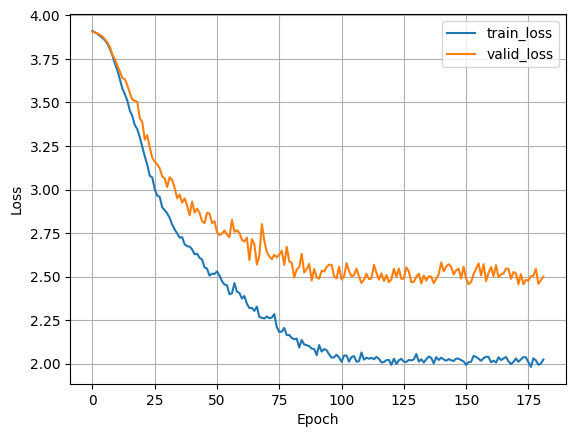

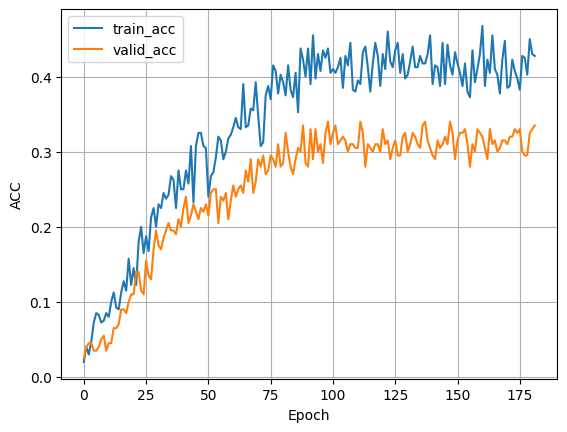

In [10]:
# Concatenate metric files from all versions for the given model
log_dir = f"logs/crnn-esc50"
all_metrics = []

if not os.path.exists(log_dir):
    print(f"No se encontró el directorio de logs para el modelo CRNN. Saltando visualización.")
    exit()
for version in os.listdir(log_dir):
    if not version.startswith("version_"):
        continue
    version_dir = os.path.join(log_dir, version)
    metrics_file = os.path.join(version_dir, "metrics.csv")
    if os.path.exists(metrics_file):
        df = pd.read_csv(metrics_file)
        all_metrics.append(df)

if not all_metrics:
    print(f"No se encontraron archivos de métricas para el modelo CRNN. Saltando visualización.")
    exit()

metrics = pd.concat(all_metrics, ignore_index=True)

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [11]:
from crnn_utils.model import Lightning_CRNN

import glob

checkpoints_dir = f"./checkpoints/crnn/"
all_checkpoints = []
for filename in glob.glob(os.path.join(checkpoints_dir, '*.ckpt')):
    all_checkpoints.append(filename)

best_checkpoint = max(all_checkpoints, key=os.path.getmtime)
print(f"Mejor checkpoint encontrado: {best_checkpoint}")

best_model = Lightning_CRNN.load_from_checkpoint(best_checkpoint)

logger = CSVLogger(save_dir="logs", name="crnn-esc50", version="eval")

trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[],
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=False,
    log_every_n_steps=10,
)

trainer.test(best_model, datamodule=data_module)

Mejor checkpoint encontrado: ./checkpoints/crnn/epoch=98-step=693.ckpt


INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.26499998569488525    │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.26499998569488525}]

## Discussion y Conclusiones

La implementación con Lightning permitió tener un código más limpio y modular, además de poder gestionar el entrenamiento distribuido de manera automática. Es importante mencionar el registro de callbacks para monitoreo y checkpointing, sin necesidad de agregar la lógica necesaria en la implementación del modelo.
 
Durante la investigación se aplicaron algunos métodos de data augmentation. No obstante solo algunos tuvieron un impacto significativo en el entrenamiento. También se aplicaron técnicas de regularización para evitar el sobreajuste. Se evidenció una reducción significativa en el sobreajuste. Sin embargo, el accuracy se reducía a medida que se incorporaban más técnicas de regularización y data augmentation por lo que se decidió dejar solo algunas y reducir las probabilidades de aplicación de las mismas.
 
La CRNN demuestra ser una arquitectura viable para clasificación de sonidos ambientales, aprovechando tanto características espectrales como temporales. No obstante, el modelo presenta un bajo desempeño en el conjunto de prueba, con una exactitud del 30%. Esto sugiere un posible sobreajuste debido al elevado número de parámetros, lo que permitió que el modelo se ajustara en exceso a los datos de entrenamiento sin generalizar adecuadamente al conjunto de prueba. Sin embargo, la implementación es escalable y puede adaptarse fácilmente a otros datasets de clasificación de audio. Con un ajuste adecuado de hiperparámetros, para el dataset ESC-50, esta implementación debería alcanzar accuracy entre 50%, que aunque debajo del performance de otros métodos del estado del arte
 
Existe margen significativo para mejoras mediante optimización de hiperparámetros, técnicas de regularización avanzadas y arquitecturas más sofisticadas como Vision Transformers. También se puede explorar la posibilidad de hacer transfer learning con modelos pre-entrenados con dataset similares. De todas maneras, la implementación presenta una base sólida para clasificación de audio que puede servir como punto de partida para investigaciones más avanzadas en el área.